In [665]:
#Dependencies
import graspy
import pdb
import myModule
from mgcpy.independence_tests.mgc import MGC
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from utils import cartprod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import random
import seaborn as sns
import matplotlib as mpl
%matplotlib inline
from graspy.simulations import sbm
from graspy.plot import heatmap
np.random.seed(10)

#Generating simulation/test data
def data_generator(num_graphs, N, n, prob_vec, percent_vec):
    
    #Create empty tensor for data to be added to,
    #as well as tensors to store each data type
    
    num_types = len(percent_vec)
    num = [int(num_graphs * a) for a in percent_vec]
    
    data = np.zeros((num_graphs,N,N))
    y_label = np.zeros((num_graphs,1))
    p_tensor = np.zeros((num_types,N,N))
    
    L_ind = random.sample(range(0, num_graphs), num_graphs)
    
    for i in range(num_types):
        types = np.zeros((num[i],N,N))
        
        for j in range(len(types)):
            types[j] = sbm(n=n, p=prob_vec[i])
        data[L_ind[:num[i]]] = types
        y_label[L_ind[:num[i]]] = i
        L_ind = L_ind[num[i]:]
        
        prob_mat = 2*np.ones((1,N))
        for k in range(len(n)):
            count = 0
            first_row = 2*np.ones((1,N))
            for L in range(len(n)):
                vec = np.repeat(prob_vec[i][k][L],n[L])
                first_row = np.append(first_row,vec)
                first_row = first_row[first_row != 2]
            first_row = np.tile(first_row, (n[k],1))
            prob_mat = np.vstack( (prob_mat, first_row) )
        p_tensor[i] = prob_mat[1:]
            
    y_label = y_label.astype(int)
    #y_label = y_label.tolist()
    
    return data, y_label, p_tensor

def mat_likelihood(A, P_hat, domain, pi):
    pi = np.log(pi)
    A_complement = 1 - A
    P_hat_complement = 1 - P_hat
    types_ = 0
    count = 1
    for i in range(len(P_hat)):
        intermediate = np.triu(np.multiply(np.power(P_hat[i], A), np.power(P_hat_complement[i], A_complement)))
        intermediate = intermediate[domain]
        intermediate = np.sum(np.log(intermediate[np.nonzero(intermediate)]))
        val = intermediate + pi[i]
        if i == 0:
            final = val
        elif val > final:
            final = val
            types_ = i
        else:
            continue
    
    return types_

def classifier_method(num_graphs, N, percent_vec, prob_tensor, ss_m_n, A_data, y_label):
    vals = range(len(percent_vec))
    
    num = num_graphs * percent_vec
    
    ind = np.asarray([np.where(y_label == i)[0] for i in vals])
    
    data_subsets = np.asarray([data[j] for j in ind])

    sums = np.asarray([np.sum(a, 0) for a in data_subsets])
    
    P_hat_vec = np.asarray([np.true_divide(sums[b],num[b]) for b in range(len(num))])
    
    #Generate blank label vector
    label_estimate = np.zeros(num_graphs)
    
    for i in range(len(A_data)):
        label_estimate[i] = mat_likelihood(A_data[i], P_hat_vec, ss_m_n, percent_vec)

    return label_estimate

def non_iterative_screen(a_tensor, N, y_labels, c, opt):

    '''
    Performs iterative screening on graphs.

    Parameters

    ----------
    
    a_tensor: tensor of adjacency matrices that are going to be used for signal subgraph.

    N: Length/width of the adjacency matrices in the dictionary
    
    y_labels: the vector of labels.
    
    c: the correlation threshold value.
    
    opt: indicator of whether to use dcorr or mgc

    Returns

    -------

    values_flags: the signal subgraph of a_matrix, found through non-iterative

    vertex screening.
    '''
    mgc = MGC()
    dcorr = DCorr(which_test = 'mantel')
    rv = RVCorr(which_test="rv")
    cca = RVCorr(which_test="cca")
    
    S_hat = np.zeros((N,1))
    
    #Creates matrices by stacking the nth rows on top of each other and running mgc on those with their 
    #corresponding labels.
    for i in range(N):
        mat = a_tensor[:,i]
        if opt == "mgc":
            c_u_0, independence_test_metadata_0 = mgc.test_statistic(mat, y_labels)
            S_hat[i][0] = c_u_0
        elif opt == "dcorr":
            c_u_1, independence_test_metadata_1 = dcorr.test_statistic(mat, y_labels)
            S_hat[i][0] = c_u_1
        elif opt == "rv":
            c_u_2, independence_test_metadata_2 = rv.test_statistic(mat, y_labels)
            S_hat[i][0] = c_u_2
        else:
            c_u_3, independence_test_metadata_3 = cca.test_statistic(mat, y_labels)
            S_hat[i][0] = c_u_3
    
    S_hat = np.absolute(S_hat)
    S_hat = S_hat[:,0]
    print(S_hat)
    values_flags = np.nonzero(S_hat > c)
    values_flags = np.asarray(values_flags[0][:])
    #ind = np.argpartition(values_flags, -20)[-20:]
    
    return values_flags, S_hat
    

def iterative_screen(a_tensor, N, y_labels, delta, opt):

    '''
    Performs iterative screening on graphs.

    Parameters

    ----------
    
    a_tensor: tensor of adjacency matrices that are going to be used for signal subgraph.

    mat_n_m: Length/width of the adjacency matrices in the dictionary
    
    y_labels: the vector of labels.
    
    delta: quantile to be screened
    
    opt: indicator of which test statistic to use

    Returns

    -------

    values_flags: the signal subgraph of a_matrix, found through non-iterative

    vertex screening.
    '''
    mgc = MGC()
    dcorr = DCorr(which_test = 'unbiased')
    rv = RVCorr(which_test="rv")
    cca = RVCorr(which_test="cca")
    S_hat = np.zeros((N,1))
    
    m = len(a_tensor)
    A_temp = []
    V = np.arange(N)
    k = 1
    domain = range(N)
    
    while len(V) > 20:
        c_u_list = []
        for i in V:
            c_u, independence_test_metadata = mgc.test_statistic(a_tensor[:,i], y_labels)
            c_u_list.append(abs(c_u))
        t_k = np.quantile(c_u_list, delta, axis = 0)
        ind = [i for i,j in enumerate(c_u_list) if j > t_k]
        V = V[ind]

    #c_k, independence_test_metadata = mgc.test_statistic(a_tensor[:,V[0]], y_labels)
    #k_* = np.argmax()
    
    return V

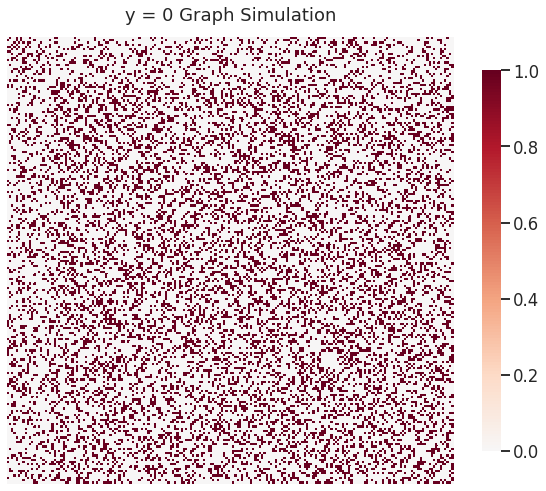

<Figure size 432x288 with 0 Axes>

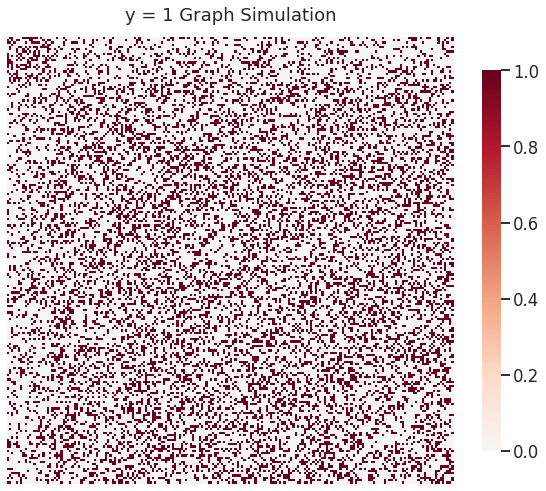

In [685]:
# Make Simulation Data
prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[.3, .2], [.2, .3]]
prob_tensor[1] = [[.4, .2], [.2, .3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

data, y_label, p_data = data_generator(100, 200, n, prob_tensor, percent_vec)
#y_label_class = y_label.reshape(100,1).astype(float)

#Plot
heatmap(data[np.where(y_label == 0)[0]][0], title='y = 0 Graph Simulation')

plt.figure()
heatmap(data[np.where(y_label == 1)[0]][1], title='y = 1 Graph Simulation')

In [608]:
fp_rate_list = []

In [620]:
ss_m_n, other = non_iterative_screen(data, 200, y_label.astype(float), 0.02, "dcorr")
    
fpr = sum(j > 19 for j in ss_m_n) / 180


In [621]:
fp_rate_list.append(fpr)

In [622]:
dcorr_fp_list = fp_rate_list

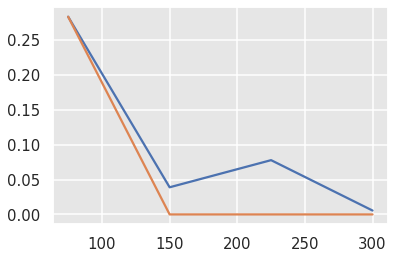

In [623]:
x_vals = [75, 150, 225, 300]
plt.plot(x_vals, mgc_fp_list)
plt.plot(x_vals, dcorr_fp_list)

In [678]:
corrvals_rv

array([0.06394296, 0.06632003, 0.06673697, 0.06414222, 0.06190735,
       0.06420666, 0.05693945, 0.06578628, 0.06878199, 0.06550262,
       0.05921765, 0.05920077, 0.06258625, 0.06576498, 0.0728034 ,
       0.07072204, 0.05480575, 0.05743676, 0.06616811, 0.05959809,
       0.05219259, 0.05020707, 0.0483872 , 0.05041313, 0.05334748,
       0.04049505, 0.04791088, 0.04276567, 0.04822329, 0.05490281,
       0.04690962, 0.04708885, 0.04208307, 0.05379677, 0.04804749,
       0.05700474, 0.05096855, 0.05690355, 0.04998812, 0.04706878,
       0.05221074, 0.04973754, 0.04822515, 0.05756085, 0.04841847,
       0.06182912, 0.0519402 , 0.04609642, 0.05209782, 0.05414374,
       0.04668356, 0.0450294 , 0.04456516, 0.04934386, 0.0437115 ,
       0.0456472 , 0.04721528, 0.0516504 , 0.05479179, 0.05025578,
       0.04132677, 0.05434851, 0.05170293, 0.05492413, 0.04614526,
       0.05033772, 0.05973816, 0.05692626, 0.0477016 , 0.0570293 ,
       0.05470174, 0.03740073, 0.04549388, 0.06253017, 0.05315

In [699]:
import sklearn.metrics as metrics

'''
ss_test_mgc, corrvals_mgc = non_iterative_screen(data, 200, y_label.astype(float), 0, "mgc")
ss_test_cca, corrvals_cca = non_iterative_screen(data, 200, y_label.astype(float), 0, "cca")
'''
#ss_test_rv, corrvals_rv = non_iterative_screen(data, 200, y_label.astype(float), 0, "rv")
'''
ss_test_dcorr, corrvals_dcorr = non_iterative_screen(data, 200, y_label.astype(float), 0, "dcorr")
'''

start_mgc = float(0.05)
end_mgc = float(0.1)
c_mgc = np.linspace(start_mgc, end_mgc, num=32)

'''
start_dcorr = float(np.amin(corrvals_dcorr))
end_dcorr = float(0.035)
c_dcorr = np.linspace(start_dcorr, end_dcorr, num=64)

start_cca = float(np.amin(corrvals_cca))
end_cca = float(0.035)
c_cca = np.linspace(start_cca, end_cca, num=64)

start_rv = float(np.amin(corrvals_rv))
end_rv = float(0.035)
c_rv = np.linspace(start_rv, end_rv, num=64)
'''

#false_pos_mgc = []
#true_pos_mgc = []
#false_pos_mgc_iter = []
#true_pos_mgc_iter = []

'''
for i in c_mgc:

    ss_m_n, other = non_iterative_screen(data, 200, y_label.astype(float), i, "mgc")
    
    #ss_m_n_iter, iterlist = iterative_screen(data, 200, y_label.astype(float), 0.05, "mgc")
    
    print(ss_m_n)
    
    true_pos_mgc.append(sum(i <= 19 for i in ss_m_n) / 20)
    
    false_pos_mgc.append(sum(j > 19 for j in ss_m_n) / 180)
    
    #true_pos_mgc_iter.append(sum(i <= 19 for i in ss_m_n_iter) / 20)
    
    #false_pos_mgc_iter.append(sum(j > 19 for j in ss_m_n_iter) / 180)


'''
'''
false_pos_dcorr = []
true_pos_dcorr = []
for i in c_mgc:

    ss_m_n, other = non_iterative_screen(data, 200, y_label.astype(float), i, "dcorr")
    
    print(ss_m_n)
    
    true_pos_dcorr.append(sum(i <= 19 for i in ss_m_n) / 20)
    
    false_pos_dcorr.append(sum(j > 19 for j in ss_m_n) / 180)

'''
'''
false_pos_cca = []
true_pos_cca = []
for i in c_cca:

    ss_m_n, other = non_iterative_screen(data, 200, y_label.astype(float), i, "cca")
    
    print(ss_m_n)
    
    true_pos_cca.append(sum(i <= 19 for i in ss_m_n) / 20)
    
    false_pos_cca.append(sum(j > 19 for j in ss_m_n) / 180)
'''

false_pos_rv = []
true_pos_rv = []


for i in c_mgc:

    ss_m_n, other = non_iterative_screen(data, 200, y_label.astype(float), i, "rv")
    
    print(ss_m_n)
    
    true_pos_rv.append(sum(i <= 19 for i in ss_m_n) / 20)
    
    false_pos_rv.append(sum(j > 19 for j in ss_m_n) / 180)


[0.08965744 0.09544496 0.09986642 0.09314619 0.08801467 0.11316581
 0.08904818 0.09449194 0.08173483 0.09748131 0.09117575 0.08033265
 0.11437696 0.0926025  0.09717895 0.08324269 0.08751768 0.12692461
 0.0944656  0.08459114 0.08852103 0.07324092 0.08793676 0.07819216
 0.08461783 0.07189626 0.07916009 0.08082805 0.08227807 0.09102426
 0.08292414 0.08695958 0.07495805 0.09095414 0.08832895 0.08184445
 0.08277281 0.09047213 0.09145641 0.08345018 0.07320195 0.10193939
 0.08335573 0.09401124 0.08375986 0.10542241 0.08028207 0.07516033
 0.08670299 0.07565645 0.07457677 0.08463971 0.06479431 0.08134664
 0.08075791 0.08227304 0.0815041  0.08368838 0.06627336 0.08214919
 0.09414157 0.07636276 0.09166768 0.09032665 0.08678173 0.07865091
 0.08809309 0.07714403 0.08967433 0.08652099 0.07302281 0.0923035
 0.08039972 0.08788927 0.08914955 0.08135061 0.09660087 0.09592424
 0.06620256 0.09580456 0.10025625 0.07464654 0.08196469 0.09151791
 0.07635001 0.07553385 0.09199886 0.07629432 0.06429292 0.07019

[0.08965744 0.09544496 0.09986642 0.09314619 0.08801467 0.11316581
 0.08904818 0.09449194 0.08173483 0.09748131 0.09117575 0.08033265
 0.11437696 0.0926025  0.09717895 0.08324269 0.08751768 0.12692461
 0.0944656  0.08459114 0.08852103 0.07324092 0.08793676 0.07819216
 0.08461783 0.07189626 0.07916009 0.08082805 0.08227807 0.09102426
 0.08292414 0.08695958 0.07495805 0.09095414 0.08832895 0.08184445
 0.08277281 0.09047213 0.09145641 0.08345018 0.07320195 0.10193939
 0.08335573 0.09401124 0.08375986 0.10542241 0.08028207 0.07516033
 0.08670299 0.07565645 0.07457677 0.08463971 0.06479431 0.08134664
 0.08075791 0.08227304 0.0815041  0.08368838 0.06627336 0.08214919
 0.09414157 0.07636276 0.09166768 0.09032665 0.08678173 0.07865091
 0.08809309 0.07714403 0.08967433 0.08652099 0.07302281 0.0923035
 0.08039972 0.08788927 0.08914955 0.08135061 0.09660087 0.09592424
 0.06620256 0.09580456 0.10025625 0.07464654 0.08196469 0.09151791
 0.07635001 0.07553385 0.09199886 0.07629432 0.06429292 0.07019

[0.08965744 0.09544496 0.09986642 0.09314619 0.08801467 0.11316581
 0.08904818 0.09449194 0.08173483 0.09748131 0.09117575 0.08033265
 0.11437696 0.0926025  0.09717895 0.08324269 0.08751768 0.12692461
 0.0944656  0.08459114 0.08852103 0.07324092 0.08793676 0.07819216
 0.08461783 0.07189626 0.07916009 0.08082805 0.08227807 0.09102426
 0.08292414 0.08695958 0.07495805 0.09095414 0.08832895 0.08184445
 0.08277281 0.09047213 0.09145641 0.08345018 0.07320195 0.10193939
 0.08335573 0.09401124 0.08375986 0.10542241 0.08028207 0.07516033
 0.08670299 0.07565645 0.07457677 0.08463971 0.06479431 0.08134664
 0.08075791 0.08227304 0.0815041  0.08368838 0.06627336 0.08214919
 0.09414157 0.07636276 0.09166768 0.09032665 0.08678173 0.07865091
 0.08809309 0.07714403 0.08967433 0.08652099 0.07302281 0.0923035
 0.08039972 0.08788927 0.08914955 0.08135061 0.09660087 0.09592424
 0.06620256 0.09580456 0.10025625 0.07464654 0.08196469 0.09151791
 0.07635001 0.07553385 0.09199886 0.07629432 0.06429292 0.07019

[0.08965744 0.09544496 0.09986642 0.09314619 0.08801467 0.11316581
 0.08904818 0.09449194 0.08173483 0.09748131 0.09117575 0.08033265
 0.11437696 0.0926025  0.09717895 0.08324269 0.08751768 0.12692461
 0.0944656  0.08459114 0.08852103 0.07324092 0.08793676 0.07819216
 0.08461783 0.07189626 0.07916009 0.08082805 0.08227807 0.09102426
 0.08292414 0.08695958 0.07495805 0.09095414 0.08832895 0.08184445
 0.08277281 0.09047213 0.09145641 0.08345018 0.07320195 0.10193939
 0.08335573 0.09401124 0.08375986 0.10542241 0.08028207 0.07516033
 0.08670299 0.07565645 0.07457677 0.08463971 0.06479431 0.08134664
 0.08075791 0.08227304 0.0815041  0.08368838 0.06627336 0.08214919
 0.09414157 0.07636276 0.09166768 0.09032665 0.08678173 0.07865091
 0.08809309 0.07714403 0.08967433 0.08652099 0.07302281 0.0923035
 0.08039972 0.08788927 0.08914955 0.08135061 0.09660087 0.09592424
 0.06620256 0.09580456 0.10025625 0.07464654 0.08196469 0.09151791
 0.07635001 0.07553385 0.09199886 0.07629432 0.06429292 0.07019

[0.08965744 0.09544496 0.09986642 0.09314619 0.08801467 0.11316581
 0.08904818 0.09449194 0.08173483 0.09748131 0.09117575 0.08033265
 0.11437696 0.0926025  0.09717895 0.08324269 0.08751768 0.12692461
 0.0944656  0.08459114 0.08852103 0.07324092 0.08793676 0.07819216
 0.08461783 0.07189626 0.07916009 0.08082805 0.08227807 0.09102426
 0.08292414 0.08695958 0.07495805 0.09095414 0.08832895 0.08184445
 0.08277281 0.09047213 0.09145641 0.08345018 0.07320195 0.10193939
 0.08335573 0.09401124 0.08375986 0.10542241 0.08028207 0.07516033
 0.08670299 0.07565645 0.07457677 0.08463971 0.06479431 0.08134664
 0.08075791 0.08227304 0.0815041  0.08368838 0.06627336 0.08214919
 0.09414157 0.07636276 0.09166768 0.09032665 0.08678173 0.07865091
 0.08809309 0.07714403 0.08967433 0.08652099 0.07302281 0.0923035
 0.08039972 0.08788927 0.08914955 0.08135061 0.09660087 0.09592424
 0.06620256 0.09580456 0.10025625 0.07464654 0.08196469 0.09151791
 0.07635001 0.07553385 0.09199886 0.07629432 0.06429292 0.07019

[0.08965744 0.09544496 0.09986642 0.09314619 0.08801467 0.11316581
 0.08904818 0.09449194 0.08173483 0.09748131 0.09117575 0.08033265
 0.11437696 0.0926025  0.09717895 0.08324269 0.08751768 0.12692461
 0.0944656  0.08459114 0.08852103 0.07324092 0.08793676 0.07819216
 0.08461783 0.07189626 0.07916009 0.08082805 0.08227807 0.09102426
 0.08292414 0.08695958 0.07495805 0.09095414 0.08832895 0.08184445
 0.08277281 0.09047213 0.09145641 0.08345018 0.07320195 0.10193939
 0.08335573 0.09401124 0.08375986 0.10542241 0.08028207 0.07516033
 0.08670299 0.07565645 0.07457677 0.08463971 0.06479431 0.08134664
 0.08075791 0.08227304 0.0815041  0.08368838 0.06627336 0.08214919
 0.09414157 0.07636276 0.09166768 0.09032665 0.08678173 0.07865091
 0.08809309 0.07714403 0.08967433 0.08652099 0.07302281 0.0923035
 0.08039972 0.08788927 0.08914955 0.08135061 0.09660087 0.09592424
 0.06620256 0.09580456 0.10025625 0.07464654 0.08196469 0.09151791
 0.07635001 0.07553385 0.09199886 0.07629432 0.06429292 0.07019

[0.08965744 0.09544496 0.09986642 0.09314619 0.08801467 0.11316581
 0.08904818 0.09449194 0.08173483 0.09748131 0.09117575 0.08033265
 0.11437696 0.0926025  0.09717895 0.08324269 0.08751768 0.12692461
 0.0944656  0.08459114 0.08852103 0.07324092 0.08793676 0.07819216
 0.08461783 0.07189626 0.07916009 0.08082805 0.08227807 0.09102426
 0.08292414 0.08695958 0.07495805 0.09095414 0.08832895 0.08184445
 0.08277281 0.09047213 0.09145641 0.08345018 0.07320195 0.10193939
 0.08335573 0.09401124 0.08375986 0.10542241 0.08028207 0.07516033
 0.08670299 0.07565645 0.07457677 0.08463971 0.06479431 0.08134664
 0.08075791 0.08227304 0.0815041  0.08368838 0.06627336 0.08214919
 0.09414157 0.07636276 0.09166768 0.09032665 0.08678173 0.07865091
 0.08809309 0.07714403 0.08967433 0.08652099 0.07302281 0.0923035
 0.08039972 0.08788927 0.08914955 0.08135061 0.09660087 0.09592424
 0.06620256 0.09580456 0.10025625 0.07464654 0.08196469 0.09151791
 0.07635001 0.07553385 0.09199886 0.07629432 0.06429292 0.07019

[0.08965744 0.09544496 0.09986642 0.09314619 0.08801467 0.11316581
 0.08904818 0.09449194 0.08173483 0.09748131 0.09117575 0.08033265
 0.11437696 0.0926025  0.09717895 0.08324269 0.08751768 0.12692461
 0.0944656  0.08459114 0.08852103 0.07324092 0.08793676 0.07819216
 0.08461783 0.07189626 0.07916009 0.08082805 0.08227807 0.09102426
 0.08292414 0.08695958 0.07495805 0.09095414 0.08832895 0.08184445
 0.08277281 0.09047213 0.09145641 0.08345018 0.07320195 0.10193939
 0.08335573 0.09401124 0.08375986 0.10542241 0.08028207 0.07516033
 0.08670299 0.07565645 0.07457677 0.08463971 0.06479431 0.08134664
 0.08075791 0.08227304 0.0815041  0.08368838 0.06627336 0.08214919
 0.09414157 0.07636276 0.09166768 0.09032665 0.08678173 0.07865091
 0.08809309 0.07714403 0.08967433 0.08652099 0.07302281 0.0923035
 0.08039972 0.08788927 0.08914955 0.08135061 0.09660087 0.09592424
 0.06620256 0.09580456 0.10025625 0.07464654 0.08196469 0.09151791
 0.07635001 0.07553385 0.09199886 0.07629432 0.06429292 0.07019

[0.08965744 0.09544496 0.09986642 0.09314619 0.08801467 0.11316581
 0.08904818 0.09449194 0.08173483 0.09748131 0.09117575 0.08033265
 0.11437696 0.0926025  0.09717895 0.08324269 0.08751768 0.12692461
 0.0944656  0.08459114 0.08852103 0.07324092 0.08793676 0.07819216
 0.08461783 0.07189626 0.07916009 0.08082805 0.08227807 0.09102426
 0.08292414 0.08695958 0.07495805 0.09095414 0.08832895 0.08184445
 0.08277281 0.09047213 0.09145641 0.08345018 0.07320195 0.10193939
 0.08335573 0.09401124 0.08375986 0.10542241 0.08028207 0.07516033
 0.08670299 0.07565645 0.07457677 0.08463971 0.06479431 0.08134664
 0.08075791 0.08227304 0.0815041  0.08368838 0.06627336 0.08214919
 0.09414157 0.07636276 0.09166768 0.09032665 0.08678173 0.07865091
 0.08809309 0.07714403 0.08967433 0.08652099 0.07302281 0.0923035
 0.08039972 0.08788927 0.08914955 0.08135061 0.09660087 0.09592424
 0.06620256 0.09580456 0.10025625 0.07464654 0.08196469 0.09151791
 0.07635001 0.07553385 0.09199886 0.07629432 0.06429292 0.07019

[0.08965744 0.09544496 0.09986642 0.09314619 0.08801467 0.11316581
 0.08904818 0.09449194 0.08173483 0.09748131 0.09117575 0.08033265
 0.11437696 0.0926025  0.09717895 0.08324269 0.08751768 0.12692461
 0.0944656  0.08459114 0.08852103 0.07324092 0.08793676 0.07819216
 0.08461783 0.07189626 0.07916009 0.08082805 0.08227807 0.09102426
 0.08292414 0.08695958 0.07495805 0.09095414 0.08832895 0.08184445
 0.08277281 0.09047213 0.09145641 0.08345018 0.07320195 0.10193939
 0.08335573 0.09401124 0.08375986 0.10542241 0.08028207 0.07516033
 0.08670299 0.07565645 0.07457677 0.08463971 0.06479431 0.08134664
 0.08075791 0.08227304 0.0815041  0.08368838 0.06627336 0.08214919
 0.09414157 0.07636276 0.09166768 0.09032665 0.08678173 0.07865091
 0.08809309 0.07714403 0.08967433 0.08652099 0.07302281 0.0923035
 0.08039972 0.08788927 0.08914955 0.08135061 0.09660087 0.09592424
 0.06620256 0.09580456 0.10025625 0.07464654 0.08196469 0.09151791
 0.07635001 0.07553385 0.09199886 0.07629432 0.06429292 0.07019

In [702]:
#true_pos_mgc = true_pos_mgc[4:]
#false_pos_mgc = false_pos_mgc[4:]
#true_pos_mgc.append(int(0))
#false_pos_mgc.append(int(0))
true_pos_rv.append(int(0))
false_pos_rv.append(int(0))

MGC:
0.685
RV:
0.7904166666666667


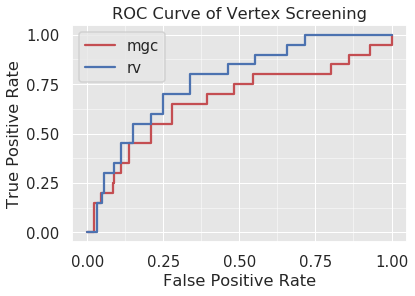

In [703]:
sns.set()
sns.set_context("talk", font_scale=.90)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
ax.set_xticks([0, 0.125, 0.25, 0.375, 0.50, 0.625, 0.750, 0.875, 1.0], minor=True)
ax.set_yticks([0, 0.125, 0.25, 0.375, 0.50, 0.625, 0.750, 0.875, 1.0], minor=True)
plt.step(false_pos_mgc, true_pos_mgc, 'r', label = "mgc")
plt.title("ROC Curve of Vertex Screening")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.yticks(np.arange(0, 1.25, 0.25))
plt.xticks(np.arange(0, 1.25, 0.25))
print("MGC:")
print(metrics.auc(false_pos_mgc, true_pos_mgc))

'''
print("DCORR:")
plt.step(false_pos_dcorr,true_pos_dcorr, 'b', label = "dcorr")
print(metrics.auc(false_pos_dcorr, true_pos_dcorr))


'''
'''
print("CCA:")
plt.figure
plt.step(false_pos_cca,true_pos_cca)
print(metrics.auc(false_pos_cca, true_pos_cca))
'''

print("RV:")
plt.step(false_pos_rv,true_pos_rv, 'b', label = "rv")
print(metrics.auc(false_pos_rv, true_pos_rv))


plt.legend()

RV:
0.7879166666666667
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9888888888888889, 0.9833333333333333, 0.9722222222222222, 0.9555555555555556, 0.9444444444444444, 0.9222222222222223, 0.8944444444444445, 0.8444444444444444, 0.7888888888888889, 0.7166666666666667, 0.6555555555555556, 0.55, 0.46111111111111114, 0.4111111111111111, 0.3388888888888889, 0.25, 0.2111111111111111, 0.15, 0.1111111111111111, 0.08888888888888889, 0.05555555555555555, 0.05, 0.03333333333333333]


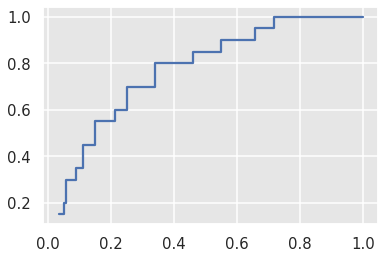

In [701]:
plt.figure
print("RV:")
plt.step(false_pos_rv,true_pos_rv)
print(metrics.auc(false_pos_rv, true_pos_rv))
print(false_pos_rv)

CCA:
0.782638888888889


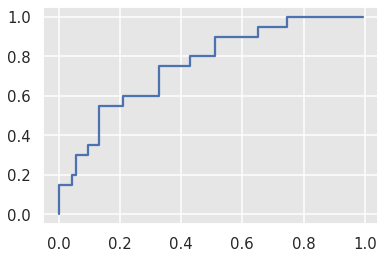

In [568]:
plt.figure
print("CCA:")
plt.step(false_pos_cca,true_pos_cca)
print(metrics.auc(false_pos_cca, true_pos_cca))

DCORR:
0.737638888888889


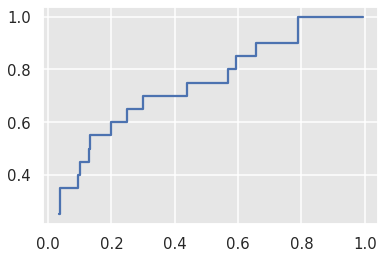

In [643]:
plt.figure
print("DCORR:")
plt.step(false_pos_dcorr,true_pos_dcorr)
print(metrics.auc(false_pos_dcorr, true_pos_dcorr))

1.0
0.0
1
1.0
0.0
2
1.0
0.0
3
1.0
0.0
4
1.0
0.0
5
1.0
0.0
6
1.0
0.0
7
1.0
0.0
8
1.0
0.0
9
1.0
0.0
10
1.0
0.0
11
1.0
0.0
12
1.0
0.0
13
1.0
0.0
14
1.0
0.0
15
1.0
0.0
16
0.0


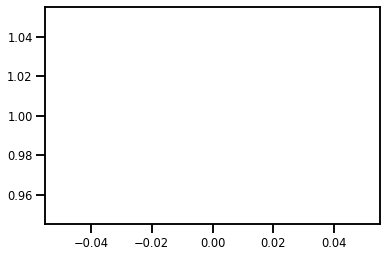

In [259]:
false_pos = []
true_pos = []
count = 0
for i in range(len(tensor_labels)):
    list_test_labels = np.ndarray.tolist(tensor_labels[i][0])
    list_test_labels = [int(i) for i in list_test_labels]
    #fpr, tpr, threshold = metrics.roc_curve(list_test_labels, y_label)
    TP = 0 
    FP = 0
    TN = 0 
    FN = 0
    for j in range(len(list_test_labels)):
        if list_test_labels[j] == 1:
            if y_label[j] == 1: 
                TP += 1
            if y_label[j] == 0: 
                FP += 1
        if list_test_labels[j] == 0:
            if y_label[j] == 1:
                FN += 1
            if y_label[j] == 0:
                TN += 1
    count += 1
    
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    
    print(tpr)
    print(fpr)
    print(count)
    false_pos.append(fpr)
    true_pos.append(tpr)

print(metrics.auc(false_pos, true_pos))
plt.plot(false_pos, true_pos)

Text(0.5, 0, 'Threshold Value (unitless)')

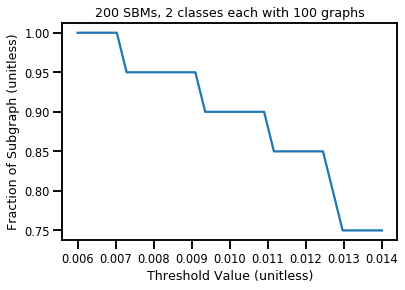

In [149]:
import seaborn as sns
sns.set_context("talk", font_scale=.70)
c = np.linspace(0.006, 0.014, num=32)
frac_array = [1, 1, 1, 1, 1, .95, .95, .95, .95, .95, .95, .95, .95, .90, .9, .9, .9, .9, .9, .9, .85, .85, .85, .85, .85, .85, 0.80, 0.75, 0.75, 0.75, 0.75, 0.75]
plt.plot(c, frac_array)
plt.title("200 SBMs, 2 classes each with 100 graphs")
plt.ylabel("Fraction of Subgraph (unitless)")
plt.xlabel("Threshold Value (unitless)")

In [320]:
count = 0
false_pos_list = []
true_pos_list = []
while count < 100:
    data, y_label, p_data = data_generator(200, 200, n, prob_tensor, percent_vec)
    ss_m_n = non_iterative_screen(data, 200, y_label.astype(float), 0, "mgc")
    true_pos_list.append(sum(i <= 20 for i in ss_m_n) / 20)
    false_pos_list.append(sum(j > 20 for j in ss_m_n) / 180)
    count += 1

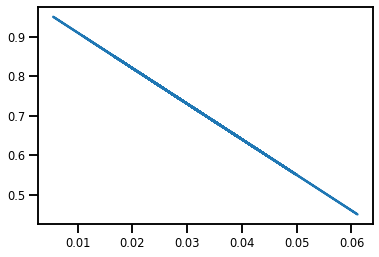

In [327]:
plt.plot(false_pos_list,true_pos_list)

In [428]:
iterative_screen(data, 200, y_label.astype(float), 0.05, "mgc")

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54
  55  56  57  58  59  60  61  63  64  65  66  67  68  70  71  72  73  74
  75  77  78  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 187 188
 189 190 191 193 194 195 196 197 198 199]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  27  28  29  30  31  32  33  34  35  36
  37  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  57
  58  59 

KeyboardInterrupt: 

In [629]:
dcorr = DCorr(which_test = 'mantel')
c_u_1, independence_test_metadata_1 = dcorr.test_statistic(data[:,1], y_label.astype(float))
print(c_u_1)

0.04739073672464723
